## 1.- Set up the enviroment

In [1]:
import pandas as pd

import numpy as np
from numpy import linalg as LA

import matplotlib.pyplot as plt
#import matplotlib.cm as cm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import copy 


#from scipy.stats import kurtosis,skew
#from scipy.linalg import fractional_matrix_power

import scipy as sp

In [2]:
#import seaborn as sns; sns.set()

In [3]:
from funciones import econophysics as rmt #Funciones is my API, its not finished yet, however im using just
# the 'renturns' function from this library 

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [5]:
def epoch(data, window_size = 40, overlap = 0):
    
    time_interval = window_size
    
    E = []
    X = []
    
    j = 0
        
    while len(data[0, (time_interval*j) - overlap*j: (time_interval*(j+1)) - overlap*j]) == time_interval:
        
        E.append( data[:, (time_interval*j) - overlap*j: (time_interval*(j+1)) - overlap*j] )
        j += 1
    
 
    #for Matrix in E:
    #    #X.append( normalization(Matrix) )
    #    X.append(np.corrcoef(normalization(Matrix)))
        
    #return np.stack(X)
    return np.stack(E)

###  Participation Ratios 
$$ PR = \sum_{i}\frac{1}{v_{i}^{4}}$$

In [6]:
def pr(vector):
    return 1/np.sum(np.power(vector,4))

In [7]:
a = [1,1,1]

In [8]:
pr(a)

0.3333333333333333

## Marchenko pastur correlated distribution
$$ \rho(\lambda) = \frac{Q}{2\pi \sigma \lambda (1-c)}\sqrt{(\lambda_{max}-\lambda)(\lambda-\lambda_{min})}$$
$$\lambda_{max} = (1-c)\sigma^{2}(1+\frac{1}{Q^{1/2}})^{2}$$
$$\lambda_{min} = (1-c)\sigma^{2}(1-\frac{1}{Q^{1/2}})^{2}$$

In [9]:
def marchenko_pastur_corr(Q, sigma = 1, corrcoef = 0):
    y = 1/Q
    c1 = corrcoef  
    b1 = (1 - c1)*np.power( sigma*( 1 + np.sqrt(1/Q)), 2)
    a1 = (1 - c1)*np.power( sigma*( 1 - np.sqrt(1/Q)), 2)
    
    f = np.vectorize(lambda x,a,b,c:
                     (1/( 2*np.pi*sigma*sigma*x*y*(1-c)))* np.sqrt( (b-x)*(x-a))*(0 if (x > b or x < a or c == 1) else 1) )
    
    x_max = (1 - c1)*np.power( sigma*( 1 + np.sqrt(1/Q)), 2)
    x_min = (1 - c1)*np.power( sigma*( 1 - np.sqrt(1/Q)), 2)
    X = np.linspace(x_min,x_max,1000)
    
    return X , f(X,a1,b1,c1)

In [10]:
def ensemble(Matrix, members = 50, rows = 38, shuffle = 'Off'):
    
    N = len(Matrix)
    
    first_element = list( np.sort(np.random.choice(N , rows , replace = False) ) )
    
    lista_de_indices =  [ first_element ]
    
    
    i = 0
    
    while i < members - 1 :
        
        indices = 0
        indices = list ( np.sort(np.random.choice(N,rows,replace = False)) )
        
        if (indices in lista_de_indices) == False:
            
            lista_de_indices.append(indices)
            i += 1 
        else :
            i -= 0
            
    if shuffle == 'On':
        
        for lista in lista_de_indices:
            np.random.shuffle(lista)
            
    Matrix = np.stack (Matrix)
    
    E = [ Matrix[ indices ] for indices in lista_de_indices ]
    Ensemble = [ np.corrcoef(matrix) for matrix in E]
    
    return np.stack(Ensemble)  

In [88]:
def ajuste_lineal(X ,Y, titulo = 'Ajuste lineal',couleur = 'blue',
                 titulox = 'Promedio del eigenvalor más grande -ensemble',
                 tituloy = 'Eigenvalor más grande'):
    
    x = X[:,np.newaxis]
    
    model = LinearRegression(fit_intercept=True)
    model.fit(x,Y)
    
    xfit = np.linspace(np.min(X)-0.05, np.max(X)+0.05, len(X))
    yfit = model.predict(xfit[:, np.newaxis])
    z =  '$ C_{avg}  = $('"%3.4f"%(model.coef_[0])+') $\lambda_{avg}$'+' '+"%3.4f"%(model.intercept_)
    #z =  '$ \lambda_{avg}  = $'"%3.4f"%(model.coef_[0])+'+ $\lambda_{max}$('"%3.4f"%(model.intercept_)+')' 
    r = '$p_{cc} = $ ' "%3.5f"%(sp.stats.pearsonr(X, Y)[0])

    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.4)
    
    main_ax = fig.add_subplot(grid[:-1, 1:])
    

    y_plot = fig.add_subplot(grid[:-1, 0], yticklabels = [], xticklabels = [] )
    x_plot = fig.add_subplot(grid[-1, 1:], yticklabels = [], xticklabels = [] )
    

    #main_ax.plot(X ,Y, 'ko',alpha = 0.5, markersize = 6.5)
    main_ax.scatter(X ,Y, color = couleur,alpha = 0.5)

    main_ax.set_title(str(titulo), fontsize = 14)
    

    main_ax.plot(xfit, yfit,'black',label = str(z),linewidth = 1)
    main_ax.plot(xfit, yfit,'black',label = str(r),linewidth = 1)
    
    x_plot.plot(X,color = couleur)
    x_plot.set_xlabel(tituloy,fontsize = 12)
        
    
    y = np.arange(len(Y))
    y_plot.plot(Y,y, color = couleur)
    y_plot.set_ylabel(titulox,fontsize = 12)
    
    y_plot.invert_xaxis()
    #y_plot.invert_yaxis()    
    
    main_ax.legend(loc = 'best')



    #plt.xlabel('Eigenvalor más grande',fontsize=14)
    #plt.ylabel(str(ylabel),fontsize=14)
    #plt.legend(loc = 'best',fontsize = 12)
    #
    plt.show()

In [16]:
def compute_histogram_bins(data, desired_bin_size):
    min_val = np.min(data)
    max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    
    return bins

In [17]:
def gaussian( X, corrected = False ):
    
    if corrected == False:
        
        x_ = np.linspace(np.min(X), np.max(X), 1000)
        m = np.mean(X)
        s = np.std(X)
        f = np.vectorize( lambda x, mu , sigma : 
                         (1/(np.sqrt(2*np.pi)*sigma))* np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma) ))
#        f = np.vectorize( lambda x, mu , sigma : 
#                         (1/np.sqrt(2*np.pi)*sigma*sigma)* np.exp(-x*x/2 ) ) 

        
        return x_, f(x_,m,s)
    
    
    if corrected == True:
        m = np.mean(X)
        s = np.std(X)
        sk = sp.stats.skew(X)
        k = sp.stats.kurtosis(X)
    
        x_ = np.linspace(np.min(X), np.max(X), 1000)

        x_ = (x_ - m )/s
   #
        He3 = lambda x : np.power(x,3) -3 * x
        He4 = lambda x : np.power(x,4) -6 * np.power(x,2) +3
        He6 = lambda x : np.power(x,6) - 15*np.power(x,4)+ 45*np.power(x,2) -15
   
        f = np.vectorize( lambda x,skew, kur: (1/np.sqrt(2*np.pi))*np.exp(-np.power(x,2)/2) * 
                         (1 + (skew/6)*He3(x) + (kur/24)*He4(x) + (np.power(skew,2)/72)*He6(x) )
                        )
    
        return x_, f(x_,sk,k)
           

### Gaussian distibution
$$ f(\hat{E}) = \frac{1}{\sqrt{2\pi}}\exp{\left(-\hat{E}^{2}\right)}$$
$$ g(\hat{E}) = \frac{1}{\sqrt{2\pi}}\exp{\left(-\hat{E}^{2}\right)}\{1+\frac{\mu_{3}}{6}He_{3}(\hat{E})+
\frac{\mu_{4}}{24}He_{4}(\hat{E})\frac{\mu_{3}^{2}}{72}He_{6}(\hat{E})\}$$

In [18]:
def gaussian2( X, corrected = False ):
    
    if corrected == False:
        
        x_ = np.linspace(np.min(X), np.max(X), 1000)
        m = np.mean(X)
        s = np.std(X)
        
        x_ = (x_ - m)/s

        f = np.vectorize( lambda x, mu , sigma : 
                         (1/np.sqrt(2*np.pi))* np.exp(-np.power(x,2)/2 ) ) 

        
        return x_, f(x_,m,s)
    
    
    if corrected == True:
        m = np.mean(X)
        s = np.std(X)
        sk = sp.stats.skew(X)
        k = sp.stats.kurtosis(X)
    
        x_ = np.linspace(np.min(X), np.max(X), 1000)

        x_ = (x_ - m )/s
   #
        He3 = lambda x : np.power(x,3) -3 * x
        He4 = lambda x : np.power(x,4) -6 * np.power(x,2) +3
        He6 = lambda x : np.power(x,6) - 15*np.power(x,4)+ 45*np.power(x,2) -15
   
        f = np.vectorize( lambda x,skew, kur: (1/np.sqrt(2*np.pi))*np.exp(-np.power(x,2)/2) * 
                         (1 + (skew/6)*He3(x) + (kur/24)*He4(x) + (np.power(skew,2)/72)*He6(x) )
                        )
    
        return x_, f(x_,sk,k)

## 2 .- Data

In [19]:
pricesAdjClose = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\pricesAdjClose.txt',sep="\t",
                             engine='python',header=None)

In [20]:
data = pricesAdjClose.values

In [96]:
#
#Data from 1992-01-02 to 2010-09-30                                               
#Crisis---------------------------------------- & Date-----& Epoch------& Dates                 
#Dot-com Bubble---------------------------------& 2000-03-10 & {[}52{]}  & From 2000-01-31 to 2000-03-27 
#Economic Effects arising from the September 11-& 2001-09-11 & {[}62{]}  & From 2001-09-04 to 2001-11-02 
#Stock market downturn of 2002------------------& 2002-10-09 & {[}68{]}  & From 2002-08-23 to 2002-10-18 
#United States Bear market of 2007-09-----------& 2007-10-11 & {[}100{]} & From 2007-09-25 to 2007-11-19 
#Financial Crisis of  2007-2008-----------------& 2008-09-16 & {[}106{]} & From 2008-09-08 to 2008-10-31 
#Flash Crash------------------------------------& 2010-05-06 & {[}116{]} & From 2010-04-12 to 2010-06-07 
#

### 2.1- 118 eigenvalues, corrcoef q = 0

In [21]:
eigenvalores =  pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\evals_1-2.txt',sep="\t",
                             engine='python',header=None)

In [22]:
e = eigenvalores.values

In [23]:
correlation_coef = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\avg_corrcoef.txt',sep="\t",
                             engine='python',header=None)

In [24]:
avc = correlation_coef.values
avc = np.concatenate(avc)

### 2.2.- 118 epoch´s 5000 members ensemble

In [25]:
Promedio = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\avg_118_epocas_5000.txt',sep="\t",
                             engine='python',header=None)
Max = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\emax_118_epocas_5000.txt',sep="\t",
                             engine='python',header=None)

#Dist = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\total_distribution_118_epocas_5000.txt',sep="\t",
#                             engine='python',header=None)

In [26]:
participation_ratios = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\PR_118_epocas_5000.txt',sep="\t",
                                   engine='python',header=None)

In [27]:
mean = Promedio.values
emax = Max.values
#distribuciones = Dist.values


In [28]:
pr1 = participation_ratios.values

### 2.3.- 16 epoch´s 5000 members ensemble

In [29]:
Promedio1 = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\avg_16_epocas_5000.txt',sep="\t",
                             engine='python',header=None)
Max1 = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\largest_eigenvalues_16_epocas_5000.txt',sep="\t",
                             engine='python',header=None)
Dist1 = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\distribucion_total_16_epocas_5000.txt',sep="\t",
                             engine='python',header=None)


In [30]:
mean1 = Promedio1.values
emax1 = Max1.values
distribuciones1 = Dist1.values


### 2.4.- 16 epoch´s 10000 members ensemble

In [31]:
#Promedio2 = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\avg_16_epocas_10000.txt',sep="\t",
#                             engine='python',header=None)
#Max2 = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\largest_eigenvalues_16_epocas_10000.txt',sep="\t",
#                             engine='python',header=None)
#Dist2 = pd.read_csv('C:\\Users\\Ale\\Documents\\Econo\\total_distribution_16_epocas_10000.txt',sep="\t",
#                             engine='python',header=None)

In [32]:
#mean2 = Promedio1.values
#emax2 = Max1.values
#distribuciones2 = Dist1.values

## 3.- Parameters

In [33]:
evals = e[:,0]

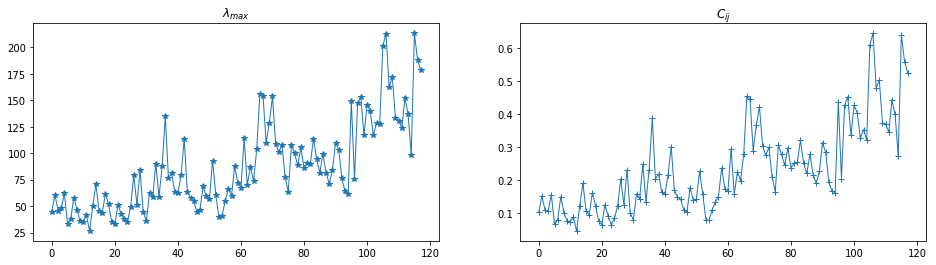

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,4))
ax[0].plot(evals,linewidth = 1, marker = '*')
ax[1].plot(avc,linewidth = 1,marker = '+')
ax[0].set_title('$\lambda_{max}$')
ax[1].set_title('$C_{ij}$')

plt.show()

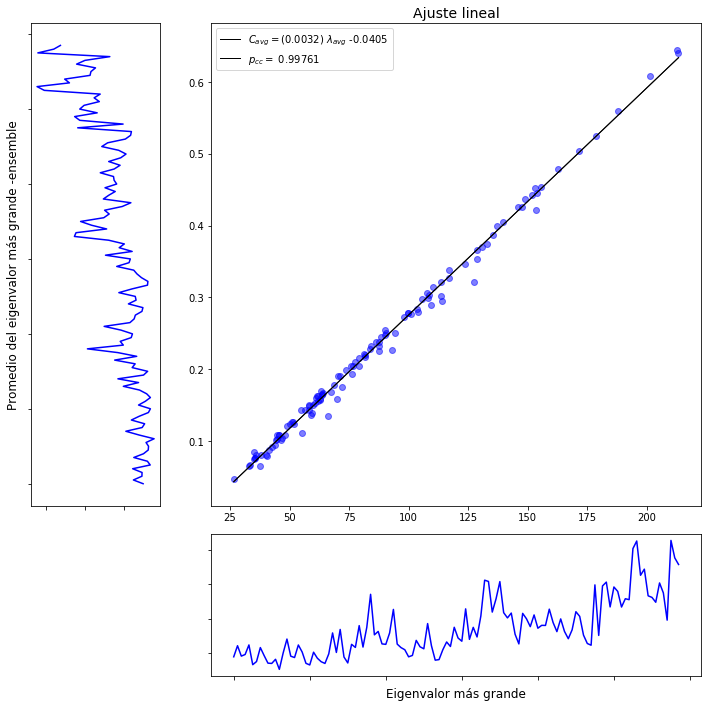

In [97]:
ajuste_lineal(evals,avc)

In [35]:
#np.random.seed(0)

In [36]:
epocas_relevantes_0  = [ 51, 61, 67, 99, 105, 115]
epocas_0  = [5, 21, 41, 51, 55, 61, 62, 67, 81, 88, 97, 99, 102, 105, 112, 115]

epocas_relevantes_20 = [102,103,121,122,134,135,197,198,209,210,229,230]
epocas_20 = [23, 59, 67, 99, 102,103,114,121,122,134,135,140,173,185,190,197,198,209,210,229,230,232]

In [37]:
color = ['blue', 'slateblue','darkslateblue','navy','darkblue',
           'mediumblue', 'deepskyblue','skyblue','dodgerblue','lightskyblue',
           'darkturquoise','cadetblue','darkcyan','c','aqua',
           'green','darkgreen']

## 4.- Action 

### Returns
$$r(t) = \frac{p(t)}{p(t-1)}-1$$

In [38]:
Rendimientos = rmt.returns(data)

In [39]:
Matrices = epoch(Rendimientos)

In [40]:
Matrices2 = epoch(Rendimientos,overlap = 20)

In [41]:
Matrices.shape

(118, 325, 40)

### Correlation Matrix
$$ C_{i,j}= \frac{\langle r_{i}r_{j}\rangle - \langle r_{i}\rangle \langle r_{j} \rangle}
{\sqrt{(\langle r_{i}^{2}\rangle-\langle r_{i} \rangle ^{2})(\langle r_{j}^{2}\rangle-\langle r_{j} \rangle ^{2})}}$$

In [43]:
C = [ np.corrcoef(matriz) for matriz in Matrices]

In [44]:
C = np.stack( C )

In [45]:
C.shape

(118, 325, 325)

In [46]:
_, v = LA.eigh(C)

In [47]:
pr2 = np.array([ pr(v[i][:,-1]) for i in range(len(v))])

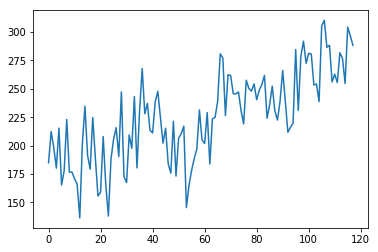

In [48]:
plt.plot(pr2)

In [49]:
Ensembles = []
Distribucion_total = []
Largest_eigenvalues = []
Smallest_eigenvalues = []
#VMAX = []
AVG = []
#PR = []

In [50]:
#for epoca in range(len(Matrices)):
for epoca in epocas_0 :
    e, u, v = 0 ,0 ,0  

    v_max = 0
    #p_r = 0
    avg = 0
    
    e = ensemble( Matrices[epoca], members = 5000, shuffle = 'On')
    
    u, v = LA.eigh(e)
    
    Distribucion_total.append( np.ndarray.flatten(u) )
    Largest_eigenvalues.append( u[:,-1])
    Smallest_eigenvalues.append( u[:,0])
    
    avg = [np.mean(correlation_matrix) for correlation_matrix in e]
    #v_max = [ v[i][:,-1] for i in range( len(v)) ]
    
#    p_r = [pr(vector) for vector in v_max]
    #VMAX.append (v_max)
    AVG.append(avg)
#    PR.append(p_r)

In [51]:
prm = [np.mean(lista) for lista in emax1]
avvg = [np.mean(lista) for lista in mean1]

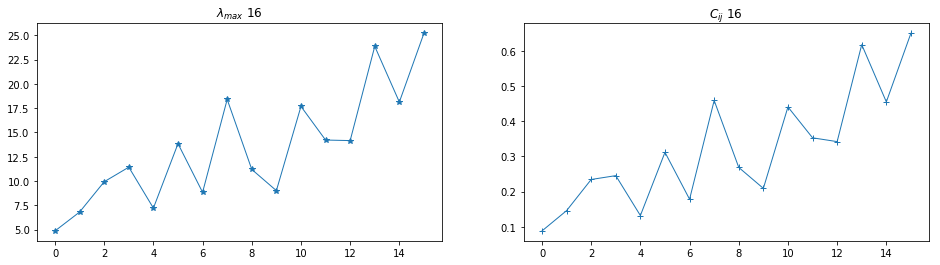

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,4))
ax[0].plot(prm,linewidth = 1, marker = '*')
ax[1].plot(avvg,linewidth = 1,marker = '+')
ax[0].set_title('$\lambda_{max}$ 16')
ax[1].set_title('$C_{ij}$ 16 ')

plt.show()

## 5000

In [53]:
e_promedio = np.array( [np.mean(lista) for lista in emax] ) 

In [54]:
avg = [ np.mean(lista) for lista in mean]


In [55]:
avg_pr = [np.mean(lista) for lista in pr1]

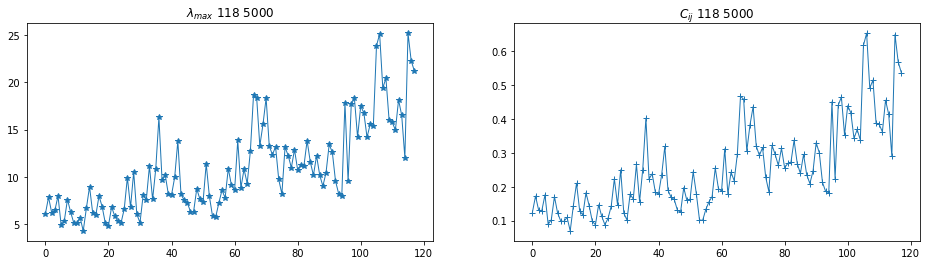

In [56]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,4))
ax[0].plot(e_promedio,linewidth = 1, marker = '*')
ax[1].plot(avg,linewidth = 1,marker = '+')
ax[0].set_title('$\lambda_{max}$ 118 5000')
ax[1].set_title('$C_{ij}$ 118 5000')

plt.show()

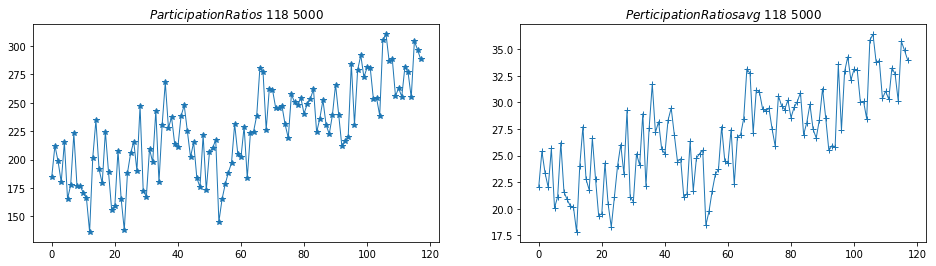

In [89]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,4))
ax[0].plot(pr2,linewidth = 1, marker = '*')
ax[1].plot(avg_pr,linewidth = 1,marker = '+')
ax[0].set_title('$Participation Ratios$ 118 5000')
ax[1].set_title('$Perticipation Ratios avg$ 118 5000')

plt.show()

In [91]:
#ajuste_lineal(evals, e_promedio,titulo = 'Ajuste lineal - Eigenvalores')

In [59]:
#np.savetxt('C:\\Users\\Ale\\Documents\\Econo\\total_distribution_118_epocas_5000.txt',Distribucion_total,delimiter = '\t')

In [60]:
#ajuste_lineal_2(avc,avg,titulo = 'Ajuste lineal - Coeficiente de correlación promedio')

In [61]:
#ajuste_lineal_3(e_promedio,avg,titulo = 'Ajuste lineal Coeficiente de correlación - Eigenvalores')

In [62]:
#ajuste_lineal(pr2,avg_pr, titulo = 'Ajuste lineal - PR ')

In [63]:
#taco

In [64]:
#for i, counter in enumerate(epocas_0):
#    x,f = marchenko_pastur_corr( Q = (40/38), corrcoef = promedios[counter])
#    histogramas( distribuciones[counter], emax[counter],[x,f],
#                couleur = color[i], epoca = counter )

In [65]:
def histogramas(lista1, lista2, AVG, epocas = 0 ,couleur = 'Blue',parte = 1  ):
#def histogramas(lista1 , lista2 , pdf, avg,couleur = 'Blue',epoca = 51 ):
    
    fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (14,16))
    plt.subplots_adjust(wspace= 0.20,hspace = 0.30,top = 0.93)
    
    plt.suptitle('Distribución de eigenvalores del ensemble de distintas épocas',fontsize = 15)
    k = 0
    if parte == 1: 
        k = 0
    if parte == 2:
        k = 8
    if parte == 3:
        k = 16
    for i in range(4):
        for j in range(2):
            x1 , f1 = marchenko_pastur_corr( Q = (40/38), corrcoef = avg[2*i+j + k])
            x2 , f2 = gaussian( lista2[2*i+j + k] )
            
            xa , xb = np.min(x2) , np.max(x2)

            bins1 = compute_histogram_bins( lista1[2*i+j + k], 0.1)
            
            ax[i,j].hist(lista1[2*i+j + k], color = couleur[2*i+j + k], ec  = 'white', bins = 100, density = True)
            ax[i,j].plot( x1, f1, color = 'coral')

            axins = inset_axes(ax[i,j], width=3, height=1.7)

            axins.hist( lista1[2*i+j + k], color = couleur[2*i+j + k] , ec='white',bins = bins1, density=True)

            axins.set_ylim(0,0.015)#0.016
            axins.set_xlim(xa,xb)
            
            ax[i,j].set_title('Época ' + str(epocas[2*i+j + k]) )
            ax[i,j].set_xlabel('$\lambda$',fontsize = 12)
            ax[i,j].set_ylabel('$p(\lambda)$', fontsize =12)
            ax[i,j].set_ylim(0,2.3)
            ax[i,j].indicate_inset_zoom(axins)

    plt.show()

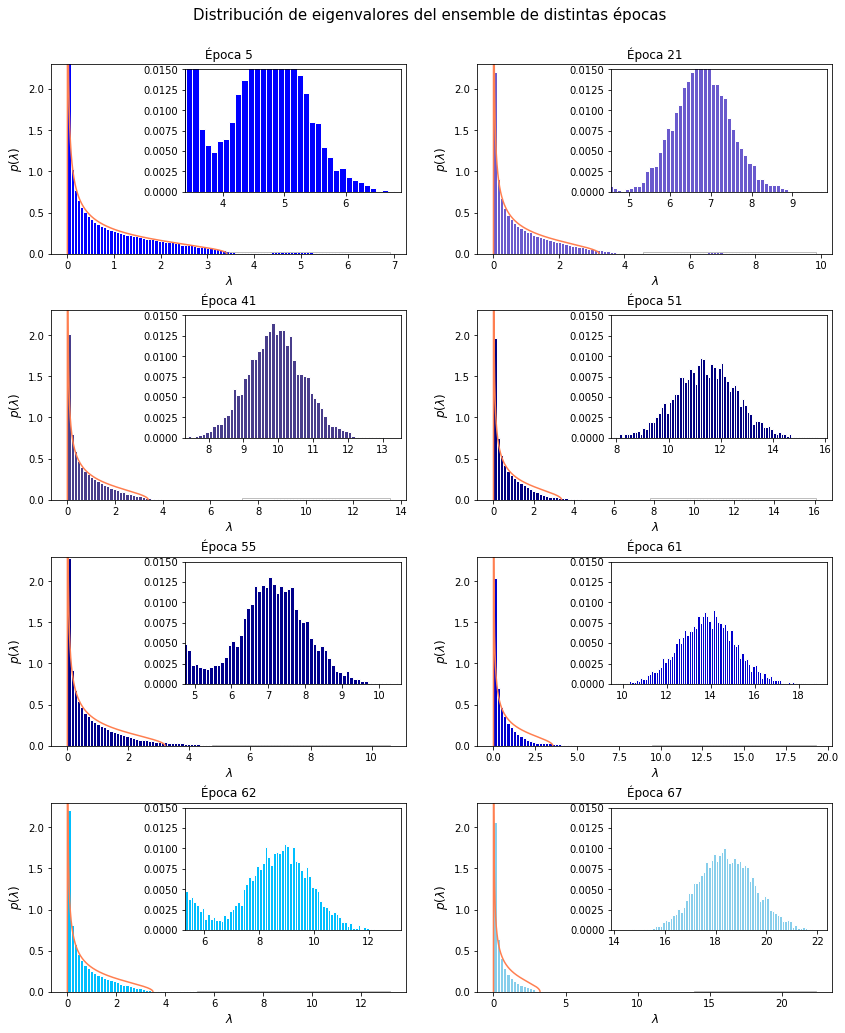

In [66]:
histogramas( lista1=distribuciones1, lista2=emax1, couleur = color,epocas = epocas_0,AVG = avg, parte = 1)
#histogramas( lista1=distribuciones1, lista2=emax1, couleur = color,epocas = epocas_0,AVG = avg, parte = 2)

In [67]:
#avg2 = [np.mean(lista) for lista in AVG]

In [68]:
#histogramas(Distribucion_total,Largest_eigenvalues,couleur=color,epocas = epocas_20,AVG=avg2,parte=1)

In [69]:
#for counter in range( 16 ):
#    x,f = marchenko_pastur_corr( Q = (40/38), corrcoef = avg[counter])
#    histogramas( distribuciones1[counter], emax1[counter],[x,f],
#                couleur = color[counter], epoca = epocas_0[counter])

In [70]:
def distribucion_emax(lista1 , epocas = 0 , couleur = 'blue', parte = 1):
    
    fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (14,16))
    plt.subplots_adjust(wspace= 0.20,hspace = 0.30,top = 0.93)
    
    plt.suptitle('Distribución del eigenvalor más grande de distintas épocas',fontsize = 15)    
    
    k = 0
    
    if parte == 2:
        k = 8
    if parte == 3:
        k = 16
    
    for i in range(4):
        for j in range(2):
            
            emaxt = (lista1[2*i+j + k] - np.mean(lista1[2*i+j + k]) )/np.std(lista1[2*i+j + k])
            bins1 = compute_histogram_bins(emaxt, 0.06)
            
            x1, f1 = gaussian2(lista1[2*i+j + k])
            x2, f2 = gaussian2(lista1[2*i+j + k],corrected = True)
            
            ax[i,j].hist(emaxt,color=couleur[2*i+j + k],ec='white',bins=bins1,density=True)
            ax[i,j].plot(x1,f1, color = 'salmon', linewidth = 2.5,label = 'Gaussiana')
            ax[i,j].plot(x2,f2, color = 'y', linewidth = 2.5,label = 'Corrección-Gaussiana')
            
            ax[i,j].set_title('Época '+str(epocas[2*i+j + k]))
            ax[i,j].set_ylabel('$P(\hat{\lambda})$')
            ax[i,j].set_xlabel('$\hat{\lambda}$')
            ax[i,j].legend(loc='best')
     
    plt.plot()


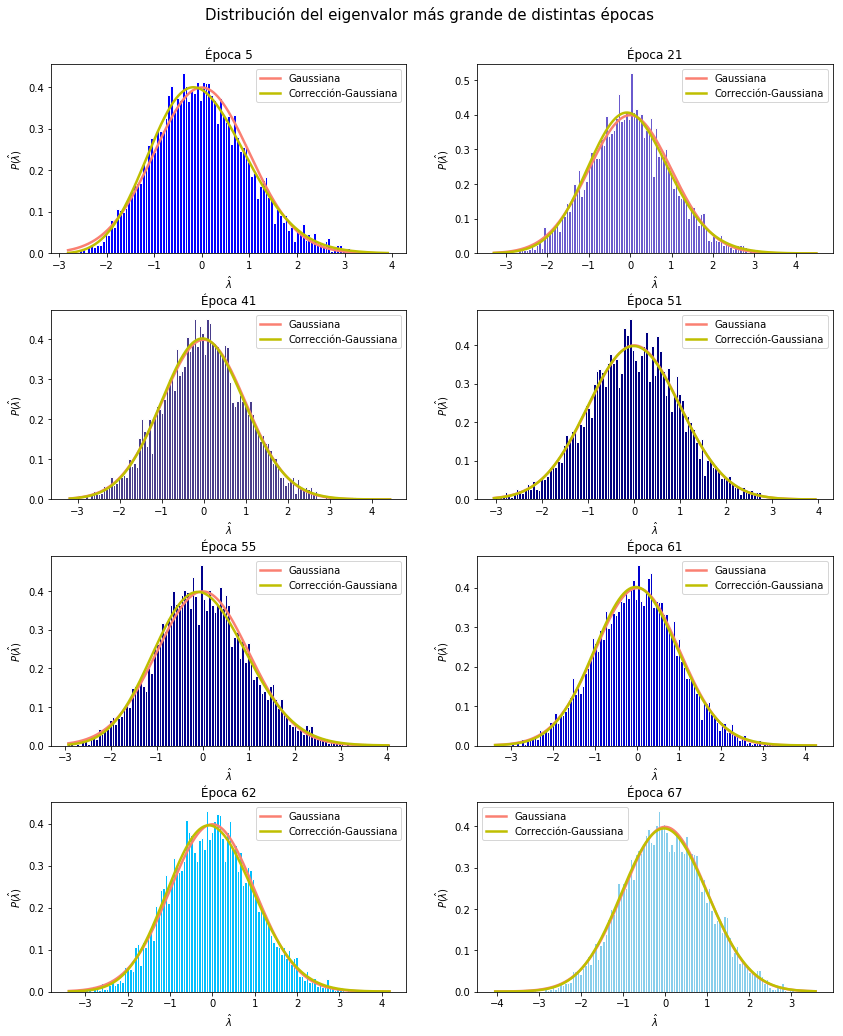

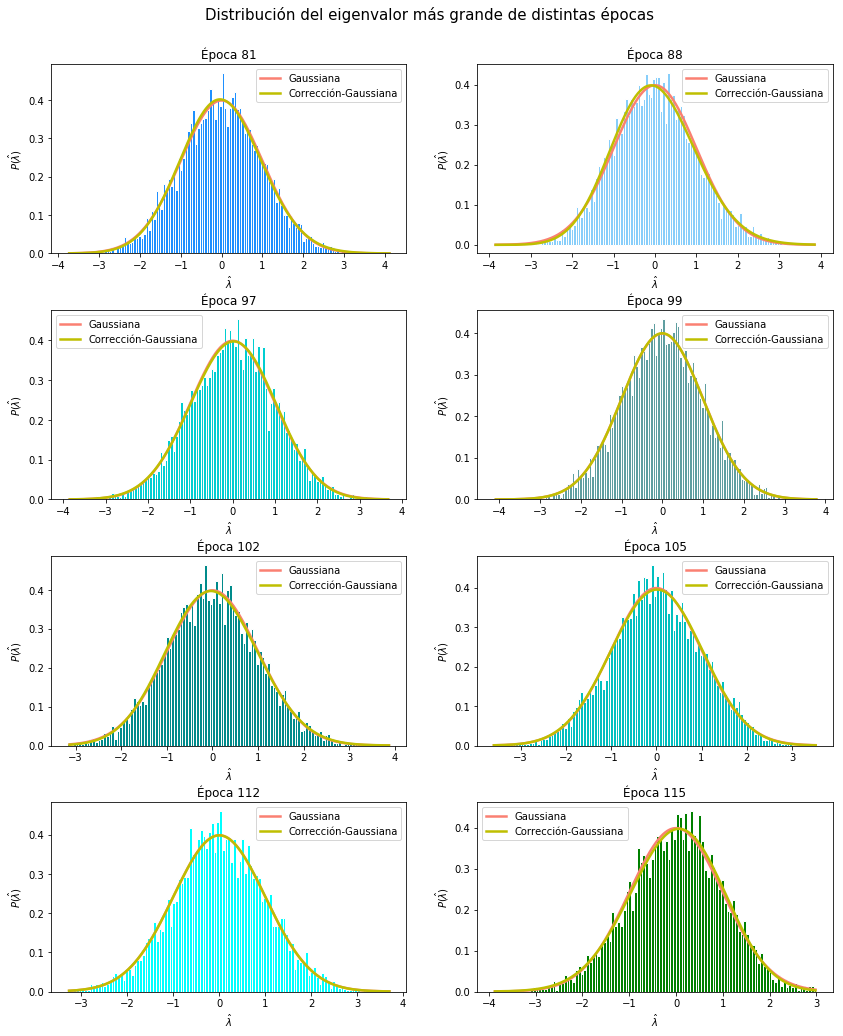

In [71]:
distribucion_emax(emax1,epocas = epocas_0, couleur = color)
distribucion_emax(emax1,epocas = epocas_0, couleur = color, parte =2)

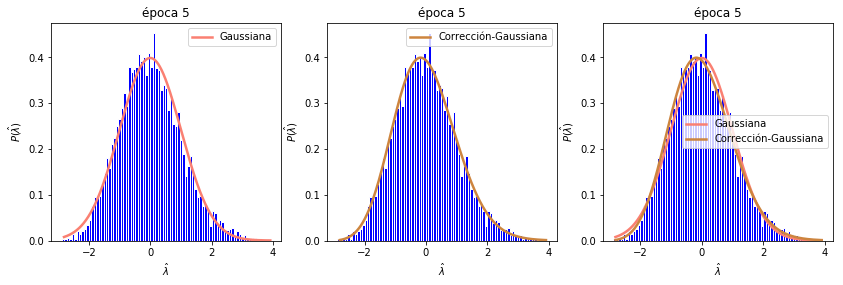

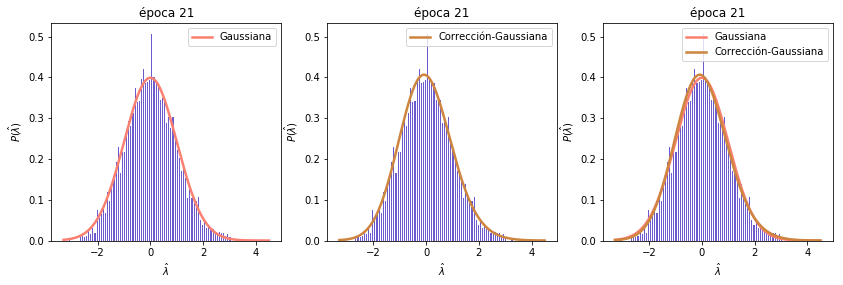

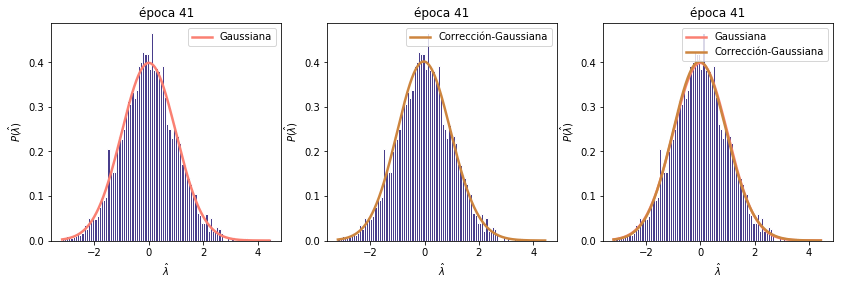

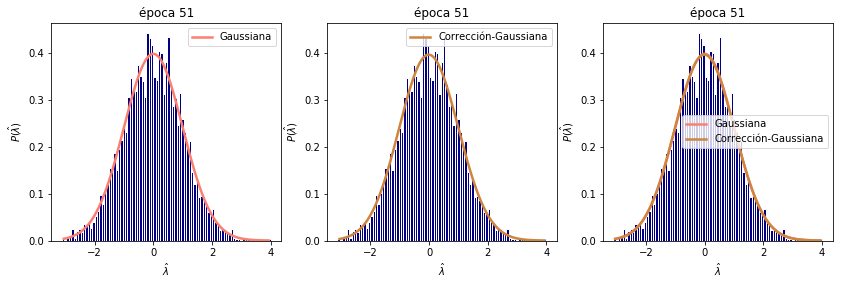

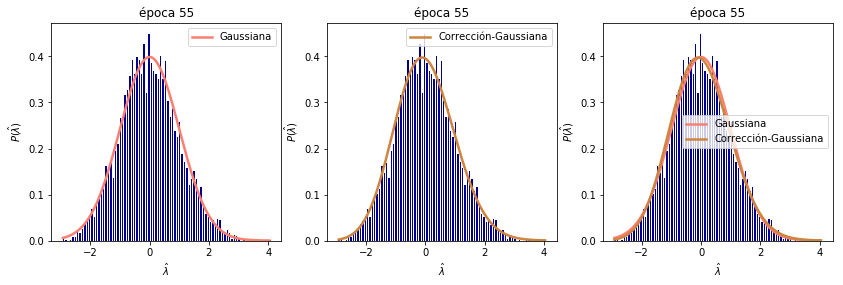

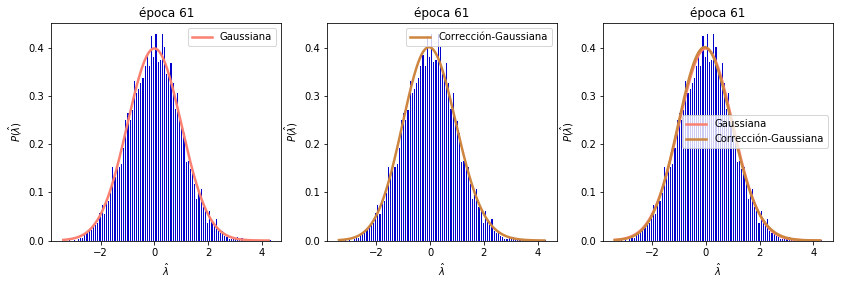

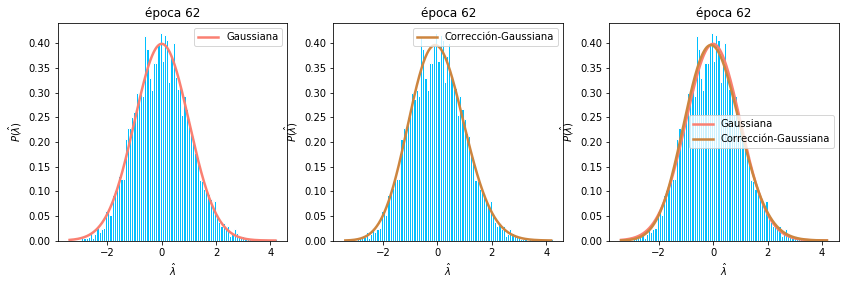

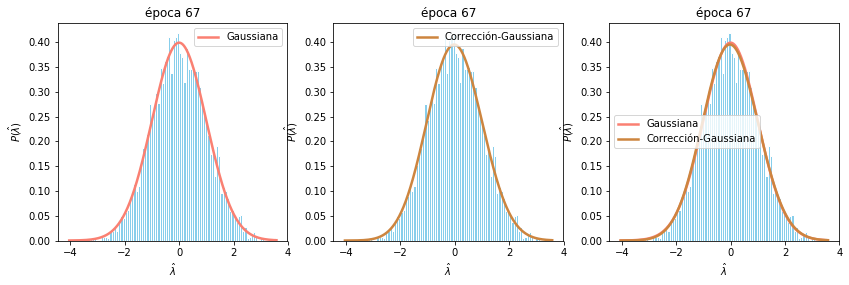

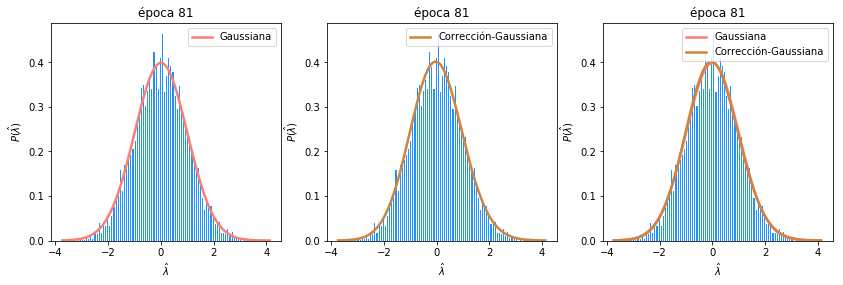

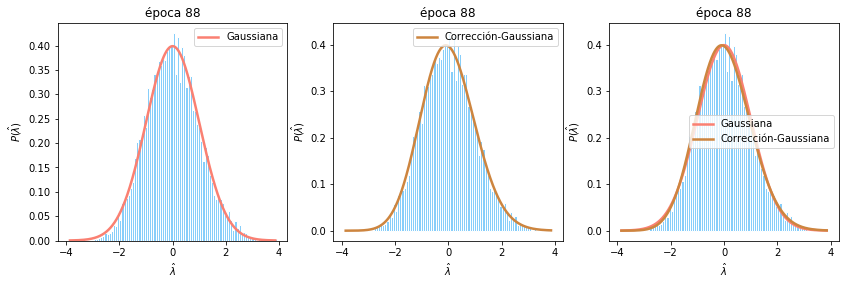

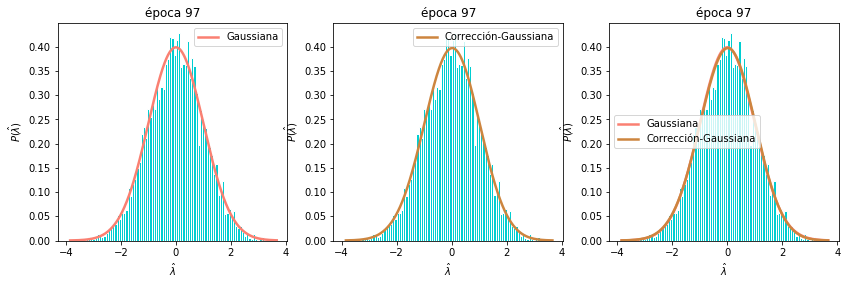

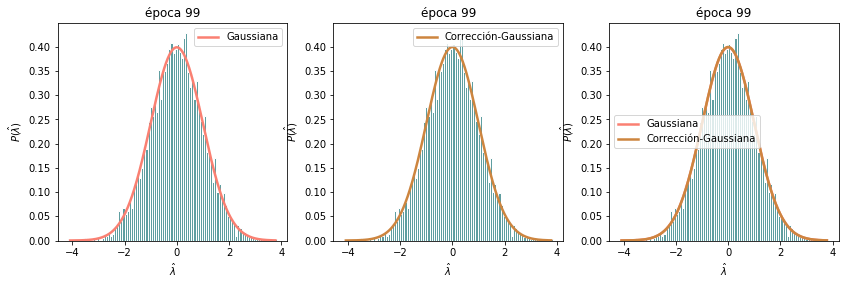

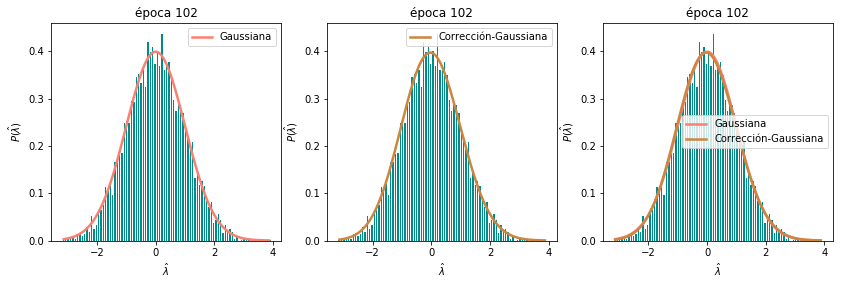

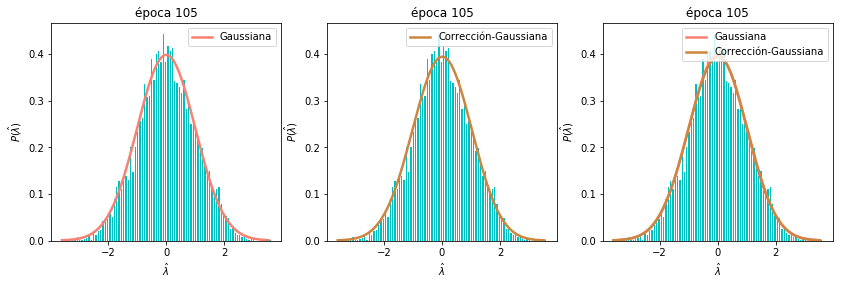

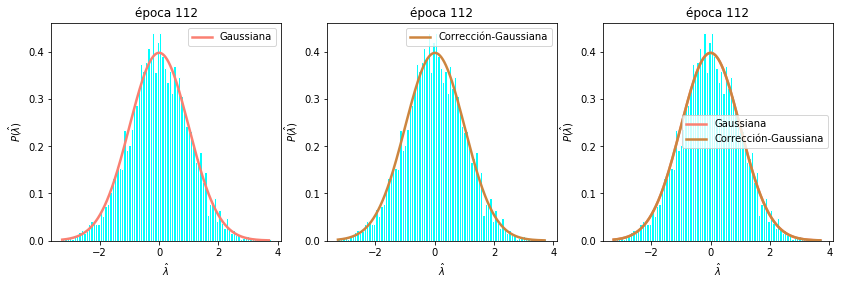

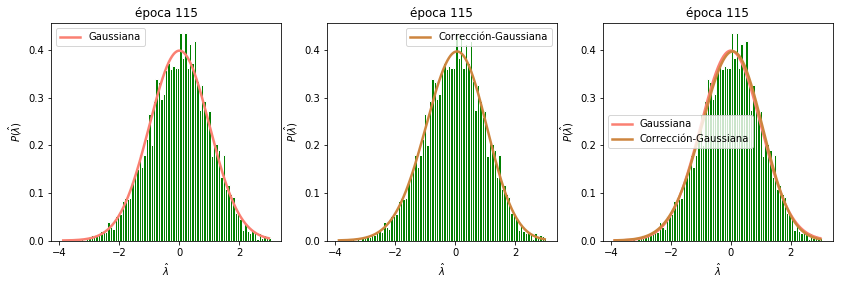

In [72]:
for counter, value in enumerate (epocas_0):
     
    emaxt = (emax1[counter] - np.mean(emax1[counter]) )/np.std(emax1[counter])

    
    bins1 = compute_histogram_bins(emaxt, 0.08)
    x, f = gaussian2(emax1[counter])

    x1, f1 = gaussian2(emax1[counter],corrected = True)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14,4))
    
    ax[0].hist( emaxt, color=color[counter],ec='white',bins=bins1,density=True)
    ax[0].plot(x,f, color = 'salmon', linewidth = 2.5,label = 'Gaussiana')
    

    ax[1].hist( emaxt, color=color[counter],ec='white',bins=bins1,density=True)
    ax[1].plot(x1,f1, color = 'peru', linewidth = 2.5,label = 'Corrección-Gaussiana')
    
    ax[2].hist( emaxt, color=color[counter],ec='white',bins=bins1,density=True)
    ax[2].plot(x,f, color = 'salmon', linewidth = 2.5,label = 'Gaussiana')
    ax[2].plot(x1,f1, color = 'peru', linewidth = 2.5,label = 'Corrección-Gaussiana')
    
    ax[0].set_title('época '+str(value))
    ax[0].set_ylabel('$P(\hat{\lambda})$')
    ax[0].set_xlabel('$\hat{\lambda}$')
    ax[0].legend(loc='best')
    #ax[0].grid(True)
    
    ax[1].set_title('época '+str(value))
    ax[1].set_ylabel('$P(\hat{\lambda})$')
    ax[1].set_xlabel('$\hat{\lambda}$')
    ax[1].legend(loc='best')
    #ax[1].grid(True)
    
    ax[2].set_title('época '+str(value))
    ax[2].set_ylabel('$P(\hat{\lambda})$')
    ax[2].set_xlabel('$\hat{\lambda}$')
    ax[2].legend(loc='best')
    #ax[2].grid(True)
    
    
    
    plt.show()

In [74]:
len(distribuciones1)

16

In [75]:
2+2

4

In [76]:
#for lista,epoca,col in zip(distribuciones1,epocas_0,color):
#    bins1 = compute_histogram_bins(lista,0.0001)
#    plt.title('Época = ' + str(epoca))
#    plt.hist(lista,bins = bins1, density = True,color = col,ec = 'white')
#    plt.xlim(0,0.005)
#    plt.show()

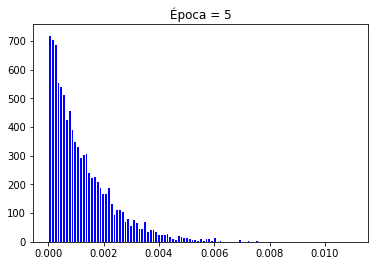

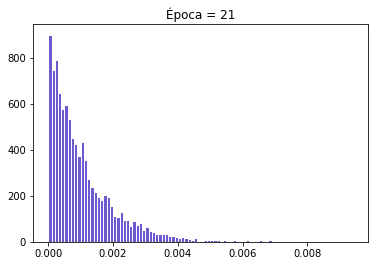

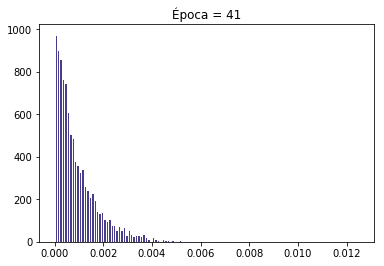

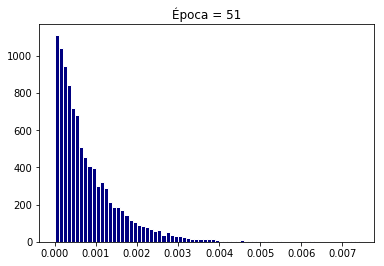

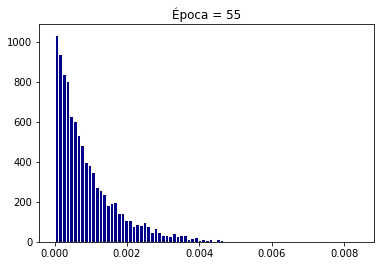

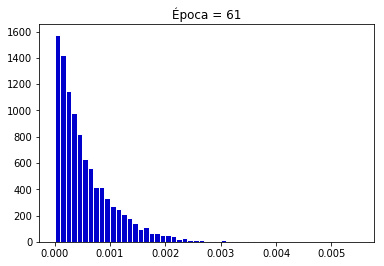

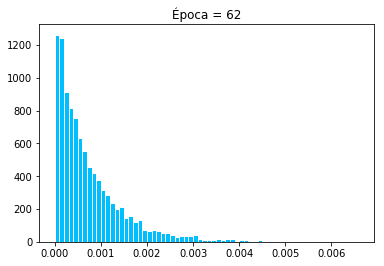

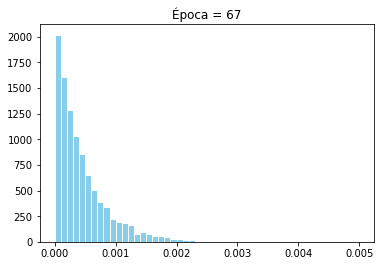

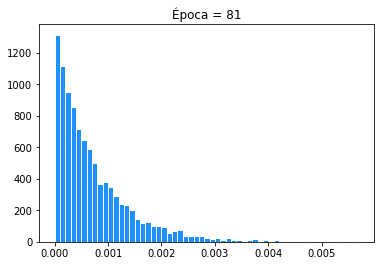

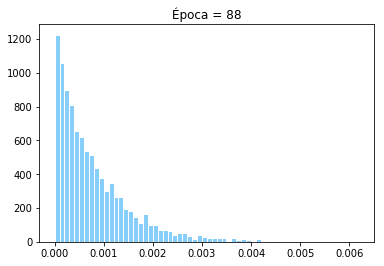

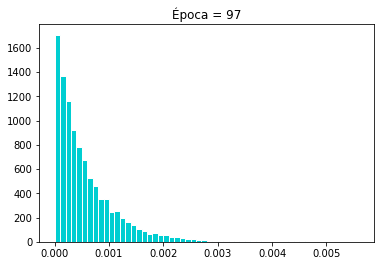

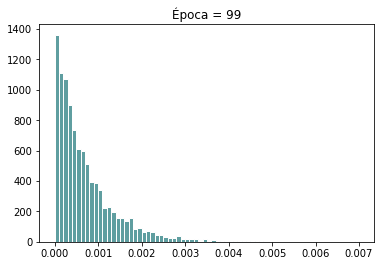

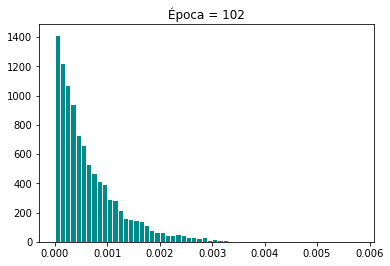

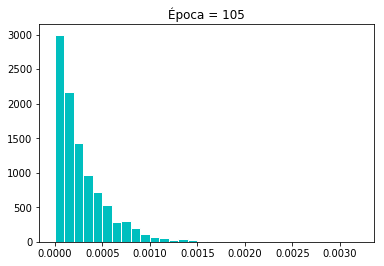

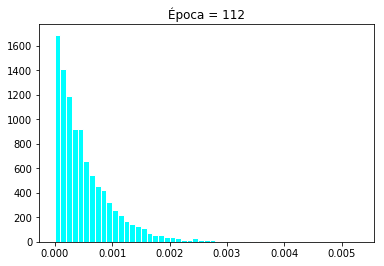

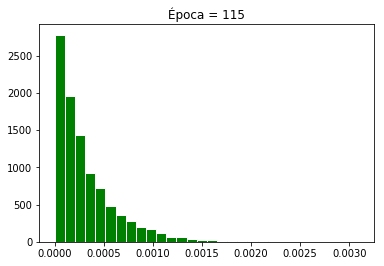

In [77]:
for lista,epoca,col in zip(Smallest_eigenvalues,epocas_0,color):
    bins1 = compute_histogram_bins(lista,0.0001)
    plt.title('Época = ' + str(epoca))
    plt.hist(lista,bins = bins1, density = True,color = col,ec = 'white')
    plt.show()

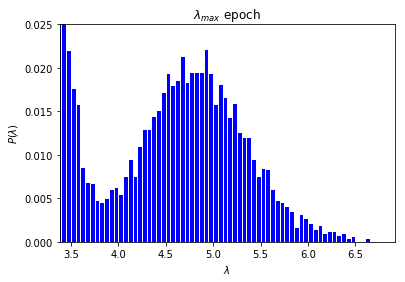

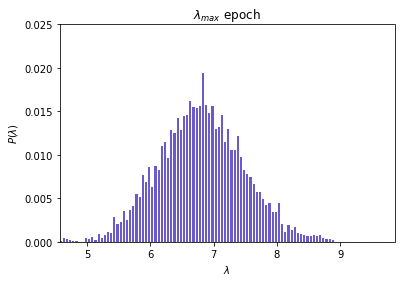

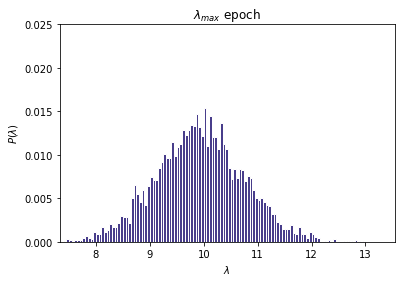

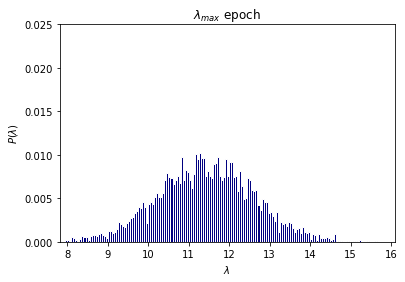

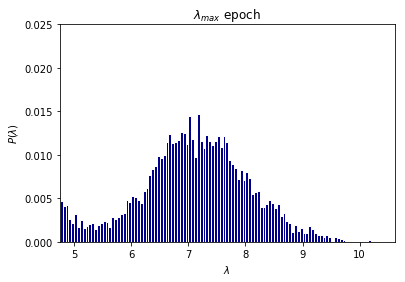

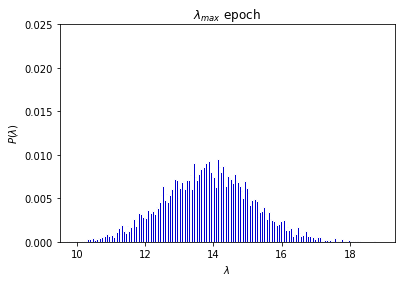

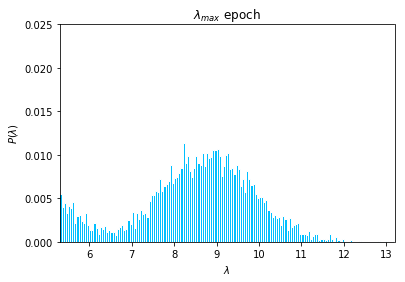

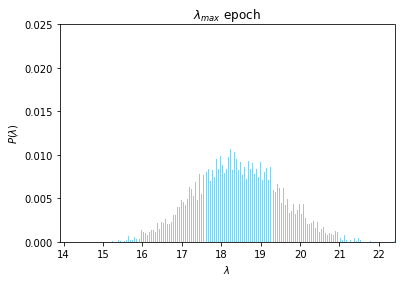

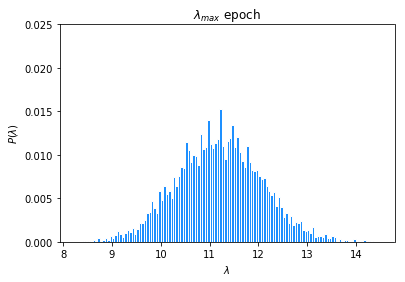

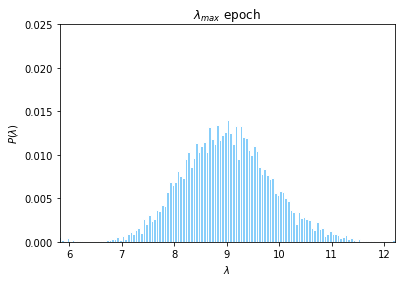

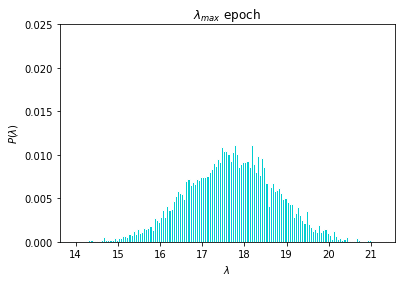

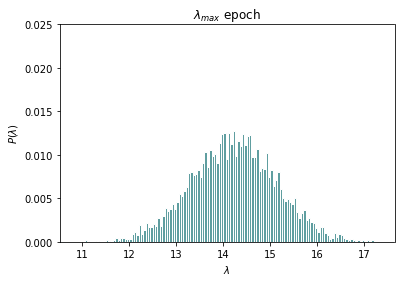

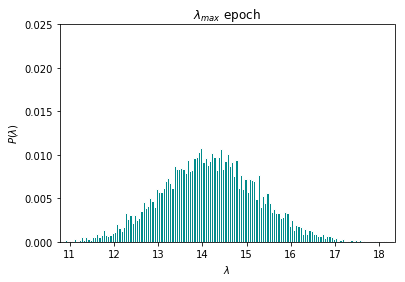

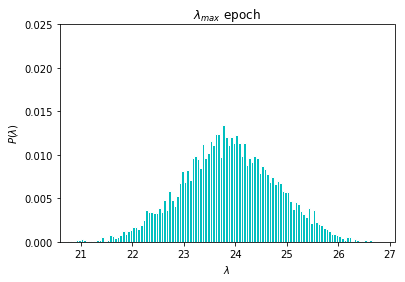

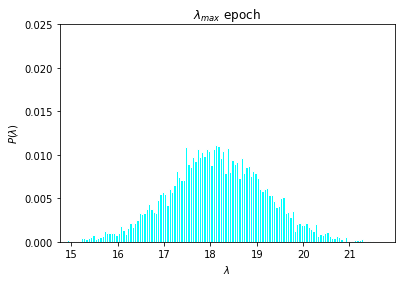

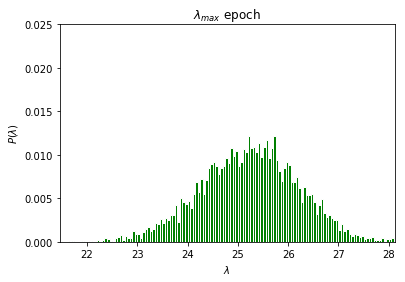

In [78]:
for i in range(16):
    x, f = gaussian(emax1[i])
    x1 = np.min(x)
    x2 = np.max(x)
    bins = compute_histogram_bins(distribuciones1[i], 0.05)
    #plt.plot(x,f, color = 'red')
    plt.hist( distribuciones1[i], color=color[i],ec='white',bins=bins,density=True)
    plt.title('$\lambda_{max}$ epoch ') 
    plt.ylabel('$P(\lambda)$')
    plt.xlabel('$\lambda$')
    plt.ylim(0,0.025)
    plt.xlim(x1,x2)
    plt.show()

In [79]:
E = np.reshape( distribuciones1[0], (5000, 38) )

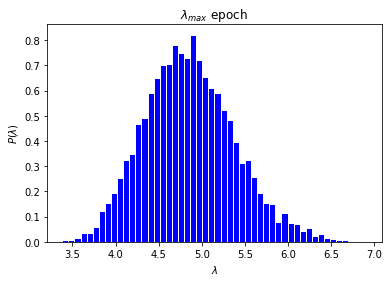

In [80]:
plt.hist( E[:,-1], color=color[0],ec='white',bins=50,density=True)
plt.title('$\lambda_{max}$ epoch ')
plt.ylabel('$P(\lambda)$')
plt.xlabel('$\lambda$')
plt.show()

In [81]:
e1 = np.ndarray.flatten(E[:,:-1])
e1.shape

(185000,)

In [82]:
e2 = E[:,-1]
e2.shape

(5000,)

In [83]:
e3 = np.concatenate ( [e1 , e2] )
e3.shape

(190000,)

In [84]:
m1 = [ np.mean(lista) for lista in emax1] 
m2 = [ np.std(lista) for lista in emax1]
m3 = [ sp.stats.skew(lista) for lista in emax1]
m4 = [ sp.stats.kurtosis(lista) for lista in emax1]

In [85]:
print(m3)

[0.3306267670019991, 0.1722336943463574, 0.061043635319414605, 0.022298367826502272, 0.2015922778424643, 0.08320607117507664, 0.15724137718968761, 0.046785164113848414, 0.07628480769515276, 0.183151585787296, -0.04369638210656517, 0.004481194425157184, 0.0690333782012681, -0.027764656028375103, -0.006164597851929891, -0.12058239799752794]


In [86]:
print(m4)

[0.07786270072354107, 0.17189344636022286, 0.06450981568632219, -0.03258806940452841, 0.0012291784569331554, 0.05771734362906544, -0.03340364760032033, -0.07316983432953128, 0.06046742274227501, 0.014313030548538386, -0.03038722670309113, 0.013480556003838462, -0.032711707829176095, -0.07640653688293542, -0.004522831697250762, -0.024279842668996743]


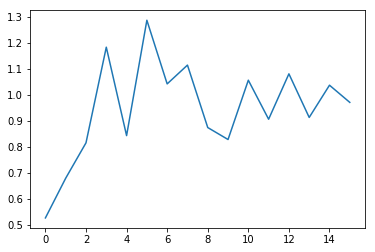

In [87]:
plt.plot(m2);